## Classificador MLP com Adam

O Classificador Perceptron Multicamadas (MLP) é baseado no Perceptron Simples, porém com camadas de neurônios antes da camada de saída [1]. Esse algoritmo é treinado com base no fluxo de informações à frente (*feedforward*), atualizando os pesos das camadas posteriores, e na retropropagação do erro (*backpropagation*) onde os neurônios das camadas anteriores têm os pesos atualizados com base no erro [2].

Para o algoritmo em questão, os pesos da camada de entrada e da camada de saída foram iniciados de forma aleatória com distribuição normal, assim como os viéses (*biases*). A cada época, os pesos são atualizados com base na taxa de aprendizado, no gradiente do erro e na saída de cada neurônio após ativação (função sigmóide na camada de entrada e função *softmax* na camada de saída). 

O erro quadrático médio de cada época (*loss*) é calculado e usado como função-custo, para diminuir a cada época. Um critério de parada foi estabelecido para quando o *loss* deixa de diminuir (i. e. não mais converge) por X épocas. O número de neurônios da camada oculta foi encontrado por meio do algoritmo de busca aleatória (*Random Search*).

Usou-se uma taxa de aprendizado de 0.01 (tanto para o MLP, como para o *Random Search*), treinamento com 5 mil épocas, critério de parada de 15 épocas seguidas e busca aleatória da quantidade de neurônios da camada oculta na faixa de 2 a 500. O *Random Search* também usa estratégia de *cross-validation* durante a busca aleatória e a estratégia utilizada foi de *Stratified KFold*, com 3 *folders*. Os demais métodos da busca aleatória foram os mesmos do MLP (ativações, taxa de aprendizado, etc).

### Sobre o dataset
A classificação foi feita para o *dataset* MNIST, de dígitos feitos à mão [3], que é composto por 60 mil imagens de treino e 10 mil imagens de teste. Todas elas são de dimensões 28x28 *pixels* e possuem suas respectivas classes (*labels*). O único pré-processamento utilizado foi a vetorização das imagens e a concatenação da matriz de imagens com um vetor de viés (*bias*), resultando em 785 atributos para a classificação. As *labels* também foram convertidas para o formato de vetor (*one hot*).

### Resultados
Dessa forma, após o treinamento, obtenção dos pesos e predição do conjunto de teste, obteve-se uma taxa de erro de **0.0684**, próximo ao resultado obtido por LeCun *et al.* [3], que obteve **0.047**.

**Referências:**
1.  D. E. Rumelhart, G. E. Hinton, and R. J. Williams. Learning representations by backpropagating errors. Nature, 323:533–536, 1986.
2.  A. Bhaya and E. Kaszkurewicz. Steepest descent with momentum for quadratic functions is a version of the conjugate gradient method. *Neural Networks*, 17(1):65–71, 2004.
3. Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." *Proceedings of the IEEE*, 86(11):2278-2324, November 1998..

2


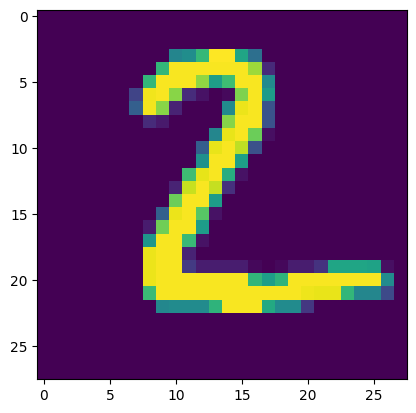

In [22]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

train_images_path = '../Datasets/MNIST/train-images.idx3-ubyte'
train_labels_path = '../Datasets/MNIST/train-labels.idx1-ubyte'
test_images_path = '../Datasets/MNIST/t10k-images.idx3-ubyte'
test_labels_path = '../Datasets/MNIST/t10k-labels.idx1-ubyte'

# Carregar o conjunto de treino para avaliação
arr_images_train = idx2numpy.convert_from_file(train_images_path)
arr_labels_train = idx2numpy.convert_from_file(train_labels_path).astype(int)

# Carregar o conjunto de teste para avaliação
arr_images_test = idx2numpy.convert_from_file(test_images_path)
arr_labels_test = idx2numpy.convert_from_file(test_labels_path).astype(int)

example = np.asarray(arr_images_test[1]).squeeze()
plt.imshow(example)

print(arr_labels_test[1])

In [23]:
print(arr_images_train.shape, arr_labels_train.shape)

(60000, 28, 28) (60000,)


In [24]:
# Transformar as imagens em vetores e normalizá-las
X_train = arr_images_train.reshape(arr_images_train.shape[0], -1)
X_test = arr_images_test.reshape(arr_images_test.shape[0], -1)

# Adicionar uma coluna de 1s para considerar o termo de bias (intercept) no modelo linear
X_train = np.column_stack((X_train, np.ones(X_train.shape[0])))
X_test = np.column_stack((X_test, np.ones(X_test.shape[0])))

# Colocar y em formato de vetor (one hot)
def one_hot_convert(vec):
    matrix = []
    for idx in vec:
      m = np.zeros((10, 1))
      m[idx] = 1
      matrix.append(m)
    return np.array(matrix)

y_train = one_hot_convert(arr_labels_train).reshape(arr_labels_train.shape[0], -1)
y_test = arr_labels_test.reshape(arr_labels_test.shape[0], -1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 785) (60000, 10)
(10000, 785) (10000, 1)


In [25]:
def adam_optimizer(step, gradient, moment, moment2, l_rate):
    
    '''
    Função que atualiza o momento e o momento de segunda ordem usando o algoritmo Adam.
    gradient: Gradiente do parâmetro.
    moment: Momento do gradiente.
    moment2: Momento do gradiente ao quadrado.
    Retorna:
        updated_moment: Momento atualizado.
        updated_moment2: Momento de segunda ordem atualizado.
        delta_theta: Variação nos parâmetros a serem aplicados.
    '''
    
    step += 1
    beta1 = 0.9
    beta2 = 0.999
    epsilon=1e-8
    
    updated_moment = beta1 * moment + (1 - beta1) * gradient
    updated_moment2 = beta2 * moment2 + (1 - beta2) * gradient**2
    bias_corrected_moment = updated_moment / (1 - beta1**step)
    bias_corrected_moment2 = updated_moment2 / (1 - beta2**step)
    delta_theta = -l_rate * bias_corrected_moment / (np.sqrt(bias_corrected_moment2) + epsilon)
    
    return step, updated_moment, updated_moment2, delta_theta

In [26]:
# Funções de ativação para o neurônio
def activate_functions(type, matrix):
    if type == 'sigmoid':
        return 1 / (1 + np.exp(-matrix))
    elif type == 'softmax':
        exp_matrix = np.exp(matrix - np.max(matrix, axis=1, keepdims=True))
        return exp_matrix / np.sum(exp_matrix, axis=1, keepdims=True)   
    elif type == 'tanh':
        return np.tanh(matrix)

# Função de treino do MLP
def mlp_train(X, y, n_neurons_hlayer, epochs, l_rate, criteria):
    n_classes = y.shape[1]
    n_features = X.shape[1]

    w_input = np.random.randn(n_features, n_neurons_hlayer) * np.sqrt(2/n_features)
    w_output = np.random.randn(n_neurons_hlayer, n_classes) * np.sqrt(2/n_neurons_hlayer)

    bias_input = np.random.randn(n_neurons_hlayer, 1) * 0.5
    bias_output = np.random.randn(n_classes, 1) * 0.5

    # Inicializando os momentos para cada camada
    moment_input = np.zeros_like(w_input)
    moment_output = np.zeros_like(w_output)
    moment_bias_input = np.zeros_like(bias_input)
    moment_bias_output = np.zeros_like(bias_output)
    
    # Inicializando os momentos de segunda ordem para cada camada
    moment2_input = np.zeros_like(w_input)
    moment2_output = np.zeros_like(w_output)
    moment2_bias_input = np.zeros_like(bias_input)
    moment2_bias_output = np.zeros_like(bias_output)

    wait = 0
    step = 0  # Contador de passos para o Adam
    for epoch in range(epochs):
        
        # Forward
        Zin = (X @ w_input) + bias_input.T
        result_in = activate_functions('sigmoid', Zin)

        Zout = (result_in @ w_output) + bias_output.T
        result_out = activate_functions('softmax', Zout)

        # Backpropagation
        error_out = result_out - y
        grad_out = error_out / len(X)

        error_in = grad_out @ w_output.T
        grad_in = error_in * result_in * (1 - result_in)

        # Atualizando os pesos e os bias da camada de saída com o algoritmo Adam
        step, moment_output, moment2_output, delta_output = adam_optimizer(
            step,
            np.dot(result_in.T, grad_out),
            moment_output,
            moment2_output,
            l_rate
        )

        # Atualizando os pesos e os bias da camada oculta com o algoritmo Adam
        step, moment_input, moment2_input, delta_input = adam_optimizer(
            step,
            np.dot(X.T, grad_in),
            moment_input,
            moment2_input,
            l_rate
        )

        # Aplicando as atualizações nos pesos e bias
        w_output += delta_output
        w_input += delta_input
        
        bias_input -= np.sum(grad_in, axis=0, keepdims=True).T * l_rate
        bias_output -= np.sum(grad_out, axis=0, keepdims=True).T * l_rate

        if epoch == 0:
            loss = np.mean((y - result_out)**2)
            print('Initial Epoch: {}, loss: {}'.format(epoch, loss))
            best_loss = loss
            
        if epoch != 0 and epoch % 5 == 0:
            loss = np.mean((y - result_out)**2)
            print('Epoch: {}, loss: {}'.format(epoch, loss))

            if loss < best_loss:
                best_loss = loss
                wait = 0
            else: wait += 1

            if wait >= criteria:
                print('Final Epoch (loss stopped): {}, loss: {}'.format(epoch, loss))
                return w_input, w_output, bias_input, bias_output

    loss = np.mean((y - result_out)**2)
    print('Last Epoch: {}, loss: {}'.format(epoch+1, loss))
                                      
    return w_input, w_output, bias_input, bias_output

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

def random_search(X, y):
    mlp = MLPClassifier(activation='logistic', learning_rate_init=0.01) # Mantendo configurações do MLP - l_rate, função de ativação sigmoid, etc

    params_search = {"hidden_layer_sizes": list(np.arange(2,500))}
    
    search = RandomizedSearchCV(mlp, param_distributions=params_search, n_jobs=-1, cv=3, verbose=5) # Busca do melhor numero de neuronios da camada
    search.fit(X, y)
    best = search.best_params_['hidden_layer_sizes']
    
    return best

# n_neurons = random_search(X_train, y_train)
n_neurons = 88
print("Neurons in hidden layer: ", n_neurons)

Neurons in hidden layer:  88


In [28]:
w_input, w_output, bias_input, bias_output = mlp_train(X_train, y_train, n_neurons, epochs=5000, l_rate=0.1, criteria=15)

Initial Epoch: 0, loss: 0.09660405516375725


C:\Users\Matheus\AppData\Local\Temp\ipykernel_11848\4292122136.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-matrix))


Epoch: 5, loss: 0.08278551059100732
Epoch: 10, loss: 0.04858951845105313
Epoch: 15, loss: 0.036310799181758
Epoch: 20, loss: 0.0283752013735638
Epoch: 25, loss: 0.023808212841314527
Epoch: 30, loss: 0.021489312812909358
Epoch: 35, loss: 0.01935287721974134
Epoch: 40, loss: 0.01782908163233446
Epoch: 45, loss: 0.016847671116056458
Epoch: 50, loss: 0.01578329781657354
Epoch: 55, loss: 0.015688717159168832
Epoch: 60, loss: 0.014730051915322047
Epoch: 65, loss: 0.014903467976606143
Epoch: 70, loss: 0.014340961460017383
Epoch: 75, loss: 0.014335210560323743
Epoch: 80, loss: 0.014675360164769424
Epoch: 85, loss: 0.014869354552510507
Epoch: 90, loss: 0.014289117145718308
Epoch: 95, loss: 0.013784367186168359
Epoch: 100, loss: 0.013890654556207489
Epoch: 105, loss: 0.013365169414257007
Epoch: 110, loss: 0.013251496370949911
Epoch: 115, loss: 0.013312473556635543
Epoch: 120, loss: 0.012846142483299235
Epoch: 125, loss: 0.012615065494689737
Epoch: 130, loss: 0.013263753072465823
Epoch: 135, loss

In [29]:
# Função de predição do MLP
def mlp_predict(X, w_in, w_out, bias_in, bias_out):
    # Forward
    Zin = (X @ w_in) + bias_in.T
    result_in = activate_functions('sigmoid', Zin)

    Zout = (result_in @ w_out) + bias_out.T
    result_out = activate_functions('softmax', Zout)

    # Converte as saídas para as classes preditas (0 a 9) usando a função argmax
    # A classe predita será o índice do valor máximo em cada linha
    print(result_out)
    classe = np.argmax(result_out, axis=1)
    print(classe.shape)

    return np.expand_dims(classe, axis=1)

# Realizar a predição no conjunto de teste
y_pred_test = mlp_predict(X_test, w_input, w_output, bias_input, bias_output)

print(y_pred_test.shape)
print(y_test.shape)

[[4.21960363e-08 6.95321575e-07 3.89482721e-06 ... 9.99895021e-01
  8.36141577e-09 2.43833972e-05]
 [4.55164676e-04 5.79781816e-03 9.92699728e-01 ... 1.06951035e-06
  3.71546691e-06 3.29057130e-08]
 [8.64782681e-08 9.96390149e-01 2.83175644e-03 ... 2.65046026e-04
  1.19189938e-04 1.27355234e-05]
 ...
 [1.02075581e-07 8.38878786e-03 1.76614312e-05 ... 9.84513548e-03
  1.47739566e-04 1.58415003e-02]
 [1.27852690e-05 8.64500271e-06 4.78686094e-08 ... 3.44078937e-06
  1.40130992e-02 1.47122178e-05]
 [4.49208896e-04 9.56346817e-05 7.18714888e-03 ... 4.03891413e-07
  2.83176753e-04 1.53640254e-04]]
(10000,)
(10000, 1)
(10000, 1)


C:\Users\Matheus\AppData\Local\Temp\ipykernel_11848\4292122136.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-matrix))


In [30]:
# Avaliar o desempenho do classificador
error = (10000 - sum(y_pred_test == y_test)) / 10000 
print("Error rate: {}".format(error[0]))

Error rate: 0.0806
